PART 1
Write a python script to measure the heights of the poles in image coordinates (you can write some code to automatically select points in the image, or you can hard-code these measurements). From these image measurements and the 3D quantities specified above, derive and compute an estimate for the camera focal length, and then the 3D height of the blue pole.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [2]:
img = plt.imread('../Computer Vision/a1-pole-length.png')

<function matplotlib.pyplot.show(close=None, block=None)>

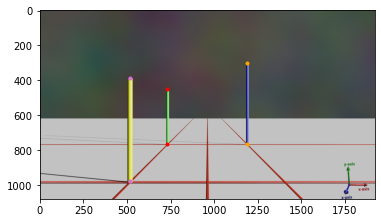

In [3]:
plt.imshow(img)
plt.plot(520, 975, marker='.', color="orchid")
plt.plot(520, 385, marker='.', color="orchid")
plt.plot(732, 765, marker='.', color="red")
plt.plot(732, 450, marker='.', color="red")
plt.plot(1190, 765, marker='.', color="orange")
plt.plot(1190, 300, marker='.', color="orange")
plt.show

#opencv
#ginput

In [4]:
# Hard coded image coordinates from points above
# Yellow Pole
x1_yel, y1_yel = 520, 975
x2_yel, y2_yel = 520, 385

# Green Pole
x1_green, y1_green = 732, 765
x2_green, y2_green = 732, 450

# Blue Pole
x1_blue, y1_blue = 1190, 765
x2_blue, y2_blue = 1190,300

In [5]:
h_yel = sqrt(((x2_yel-x1_yel)**2+(y2_yel-y1_yel)**2)) # finding yellow height

In [6]:
h_green = sqrt(((x2_green-x1_green)**2+(y2_green-y1_green)**2)) # finding green height

In [7]:
h_blue = sqrt(((x2_blue-x1_blue)**2+(y2_blue-y1_blue)**2)) # finding blue height

In [8]:
print(h_yel, h_green, h_blue)

590.0 315.0 465.0


In [9]:
# given values
Y_yel = 4
Y_green = 4
l = 53333

In [10]:
# we know from our perspective projection equations that y/Y=f/Z
# we also know that Z_green = Z_yel + 17 (from given information)
# so we can deduce that Z_yel = (h_green*17)/(h_yel-h_green)
Z_yel = (h_green*17)/(h_yel-h_green)
print(Z_yel)

19.472727272727273


In [11]:
# now we can plug in to solve for f in meters
f = ((h_yel*Z_yel)/Y_yel)/l
# now we convert to mm
f = f*1000
print(f)

53.85459795487358


In [12]:
# we can use perspective projection to find Y_blue = ((h_blue)*(Z_yel+17)/(f/1000))/l
Y_blue = ((h_blue)*(Z_yel+17)/(f/1000))/l
print(Y_blue)

5.904761904761904


PART 2

In [13]:
# DOLLY ZOOM
import copy
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from math import sin, cos


In [14]:
# scene parameters
f_start    = 0.3 # the focal length f to start
grid_count = 20 # the number of squares in one dimension of the plane
Z_start    = 100 # the starting distance between the camera and the cube
Z_end      = 40 # the last distance between camera and the cube
steps      = 30 # number of dolly zoom steps to take between Z_start and Z_end

In [15]:
# WRITE THIS FUNCTION -- EVERYTHING ELSE IS SUPPLIED

# build extrinsic (M) and intrinsic (K) matrix and return their product K @ M, a 3 x 4 transformation matrix
# in_trans is a 1D array containing the rotation Rx,Ry,RZ (in degrees), and translation Tx,Ty,Tz
# f is the camera focal length
# transformation matrix should be a numpy matrix of size 3 x 4
def get_projective_matrix(in_trns, f):
    K = np.array([[f,0,0],[0,f,0],[0,0,1]]) # intrinsic matrix
    
    Rx = np.radians(in_trns[0]) #rotation (radians)
    Ry = np.radians(in_trns[1])
    Rz = np.radians(in_trns[2])
    Tx = in_trns[3]
    Ty = in_trns[4]
    Tz = in_trns[5]
    RMx = np.array([[1,0,0],[0,cos(Rx),-sin(Rx)],[0,sin(Rx),cos(Rx)]])
    RMy = np.array([[cos(Ry),0,sin(Ry)],[0,1,0],[-sin(Ry),0,cos(Ry)]])
    RMz = np.array([[cos(Rz),-sin(Rz),0],[sin(Rz),cos(Rz),0],[0,0,1]])
    RM = RMz @ RMy @ RMx
    M = np.zeros((3,4))
    M[0,3] = Tx
    M[1,3] = Ty
    M[2,3] = Tz
    M[0:3,0:3] = RM #extrinsic matrix
    
    M = K @ M
    return M

    # return the set of points on a plane in a grid form.
    # every row consist of four points which are corners of each grid square.
    # Input: the number of grids in each dimension
    # Output: the Nx4 matrix with 3D homogenous points for each square on the plane
   

In [16]:
 def get_plane_mesh(in_plane, grid_n):
    # the two edges of the square
    X = np.linspace(in_plane[0, 0], in_plane[1, 0], grid_n)
    Y = np.linspace(in_plane[1, 1], in_plane[2, 1], grid_n)
    U,V = np.meshgrid(X, Y)
    
    out = np.concatenate((U[:,:,np.newaxis], V[:,:,np.newaxis],
                          np.zeros_like(U)[:,:,np.newaxis],
                          np.ones_like(U)[:,:,np.newaxis]), axis=2)
    return out


In [17]:
# transform the object using its transform parameters and then project it on the sensor: f=focal length
def transform_points(in_obj, f):
    out_obj = dict(in_obj)
    
    XYZ = in_obj['points'].copy()
    in_trns = in_obj['transform'].copy()
    
    # perspective projection,
    M = get_projective_matrix(in_trns, f)
    
    p = M @ np.transpose(XYZ) # projection (homogenous coordinates)
    x = p[0,:]/p[2,:] # convert to non-homogenous coordinates
    y = p[1,:]/p[2,:] #
    
    # put the sensor points in the out scene
    out_obj['points'] = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
    
    return out_obj


In [18]:
# draw the single plane points
def draw_plane(in_ax, in_pts):

    c = 0
    for i in range(in_pts.shape[0]-1):
        for j in range(in_pts.shape[1]-1):
            if c%2 == 0:
                in_ax.fill([in_pts[i,j,0], in_pts[i+1,j,0], in_pts[i+1,j+1,0], in_pts[i,j+1,0]],
                           [in_pts[i,j,1], in_pts[i+1,j,1], in_pts[i+1,j+1,1], in_pts[i,j+1,1]], 'k-')
            else:
                in_ax.fill([in_pts[i,j,0], in_pts[i+1,j,0], in_pts[i+1,j+1,0], in_pts[i,j+1,0]],
                           [in_pts[i,j,1], in_pts[i+1,j,1], in_pts[i+1,j+1,1], in_pts[i,j+1,1]], 'w-')
            c = c + 1


In [19]:
# given one scene in a scene dictionary, visualize the scene
def visualize_scene(in_scene):
    
    # draw
    my_dpi = 96
    fig = plt.figure(figsize=(800/my_dpi, 400/my_dpi), dpi=my_dpi)
    ax = fig.add_subplot()
    
    # plot the ground plane
    xy = in_scene['ground_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the right plane
    xy = in_scene['right_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the left plane
    xy = in_scene['left_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the back plane
    xy = in_scene['back_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the cube
    xy = in_scene['cube']['points']
    x = xy[:,0].copy()
    y = xy[:,1].copy()

    # draw six faces of the cube
    plt.fill([x[0],x[1],x[2],x[3]],[y[0],y[1],y[2],y[3]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[4],x[5],x[6],x[7]],[y[4],y[5],y[6],y[7]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[0],x[1],x[5],x[4]],[y[0],y[1],y[5],y[4]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[1],x[2],x[6],x[5]],[y[1],y[2],y[6],y[5]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[2],x[3],x[7],x[6]],[y[2],y[3],y[7],y[6]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[3],x[0],x[4],x[7]],[y[3],y[0],y[4],y[7]],color=[0.7,0.7,0.7,0.5])

    # draw six edges of the cube
    plt.plot([x[0],x[1]],[y[0],y[1]],'ro-')
    plt.plot([x[1],x[2]],[y[1],y[2]],'ro-')
    plt.plot([x[2],x[3]],[y[2],y[3]],'ro-')
    plt.plot([x[3],x[0]],[y[3],y[0]],'ro-')

    plt.plot([x[4],x[5]],[y[4],y[5]],'ro-')
    plt.plot([x[5],x[6]],[y[5],y[6]],'ro-')
    plt.plot([x[6],x[7]],[y[6],y[7]],'ro-')
    plt.plot([x[7],x[4]],[y[7],y[4]],'ro-')

    plt.plot([x[0],x[4]],[y[0],y[4]],'ro-')
    plt.plot([x[1],x[5]],[y[1],y[5]],'ro-')
    plt.plot([x[2],x[6]],[y[2],y[6]],'ro-')
    plt.plot([x[3],x[7]],[y[3],y[7]],'ro-')

    ax.set_aspect('equal', adjustable='box')
    plt.xlim([-0.2, 0.2])
    plt.ylim([-0.1, 0.1])
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.draw()
    plt.tight_layout()
    
    # save the current plot and return this image
    plt.savefig('temp.png', dpi=my_dpi)
    image = imageio.imread('temp.png')
    os.remove('temp.png')
    return image



In [20]:
# scene dictionary has keys as object names, each object key will store object transformation and object points

# 3-D, unit-cube (homogenous coordinates)
cube = np.array([[0,0,0,1],[1,0,0,1],[1,1,0,1],[0,1,0,1],
              [0,0,1,1],[1,0,1,1],[1,1,1,1],[0,1,1,1]])

# make length of the cube 12 meters
cube[:, :3] = 12*cube[:, :3]
cube[:, :3] = cube[:, :3] - 6

height = 400 # height of the walls
plane = np.array([[0,0,0,1],[height,0,0,1],[height,height,0,1],[0,height,0,1]])

# create an empty scene
scene = {}
scene['ground_plane'] = {}
scene['right_plane'] = {}
scene['left_plane'] = {}
scene['back_plane'] = {}
scene['cube'] = {}

# put the points and transformation (Rx, Ry, Rz, Tx, Ty, Tz)
scene['ground_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['ground_plane']['transform'] = np.array([90, 0, 0,-height/2, -30, Z_start])

scene['right_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['right_plane']['transform'] = np.array([0, -90, 0, height/2, -30, Z_start])

scene['left_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['left_plane']['transform'] = np.array([0, -90, 0, -height/2, -30, Z_start])

scene['back_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['back_plane']['transform'] = np.array([0, 0, 0, -height/2, -30, height+Z_start])

scene['cube']['points'] = cube
scene['cube']['transform'] = np.array([30,30,0,0,0, Z_start])


<ipython-input-19-9bea5fe15c55>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(800/my_dpi, 400/my_dpi), dpi=my_dpi)


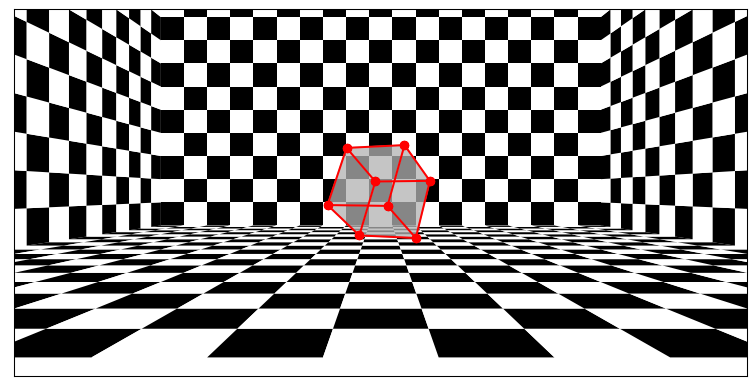

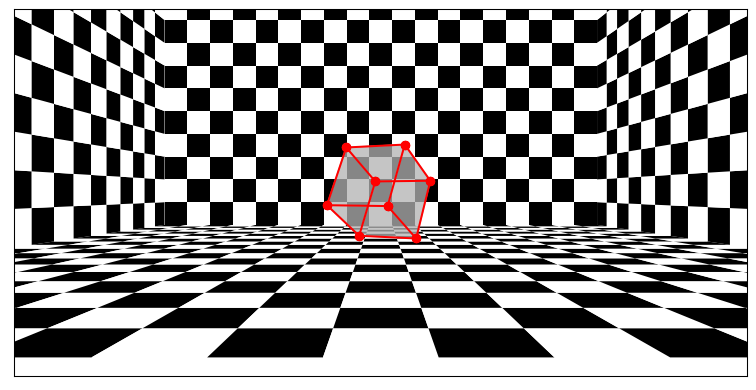

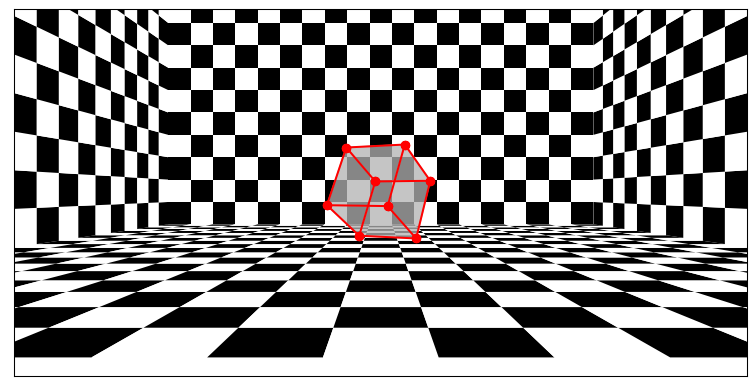

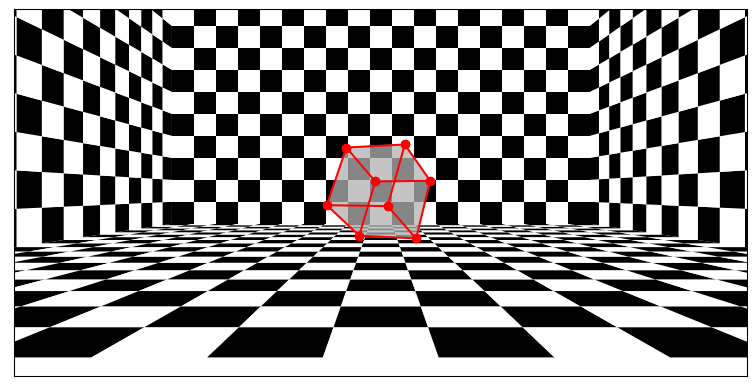

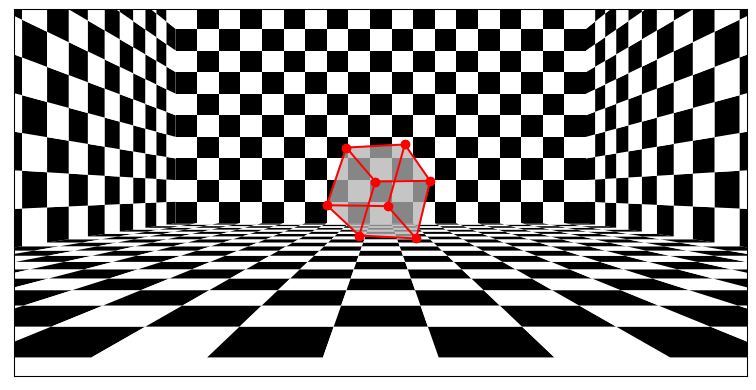

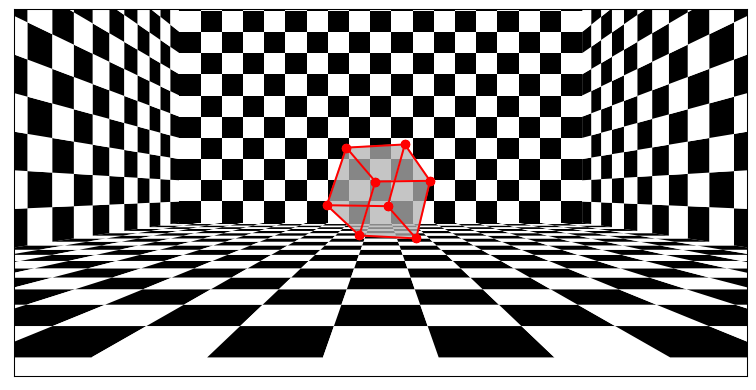

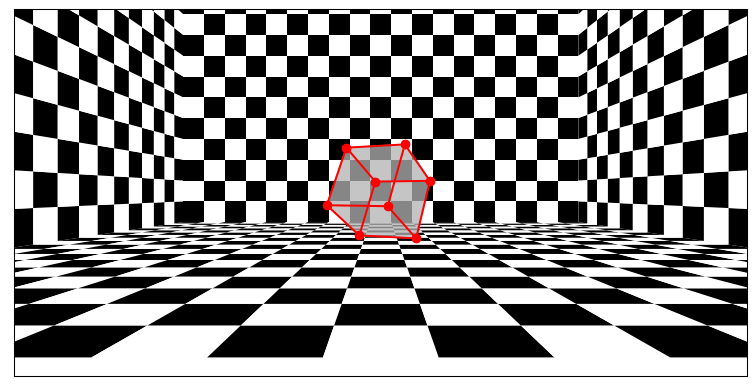

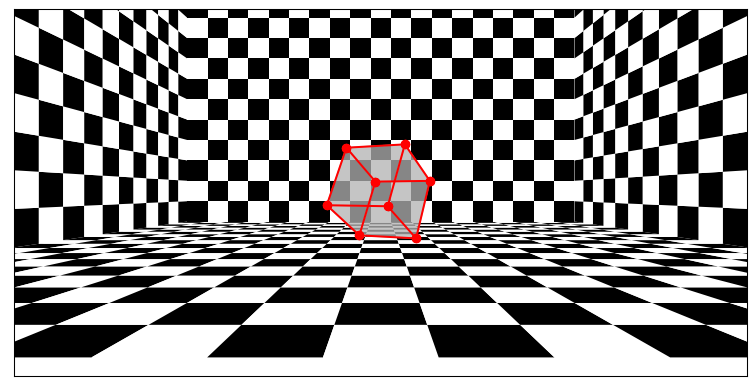

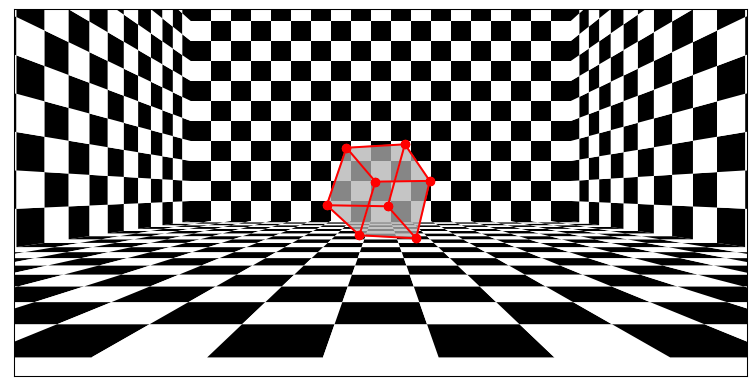

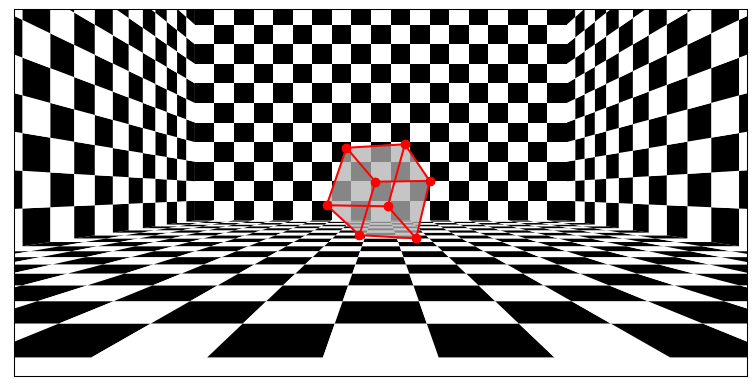

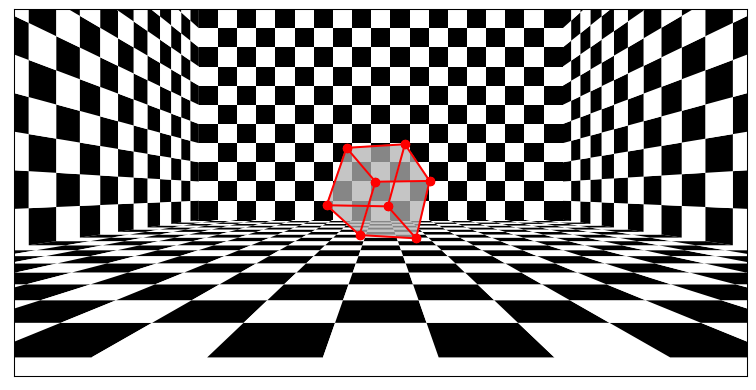

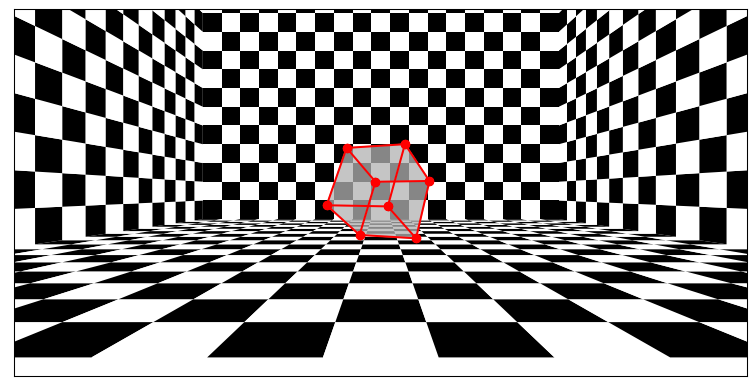

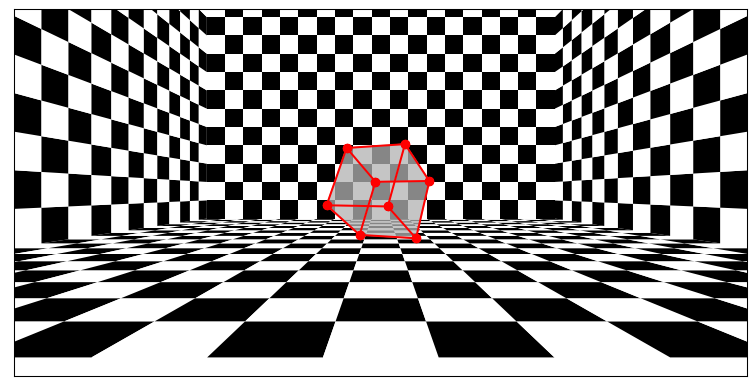

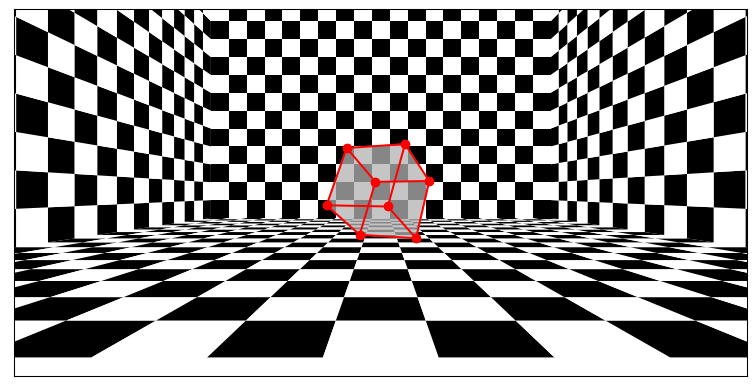

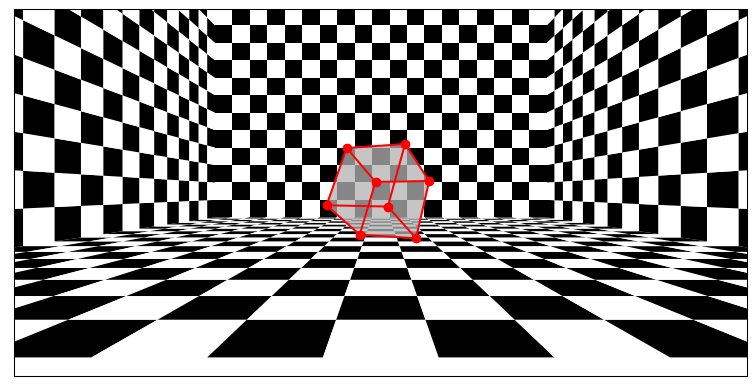

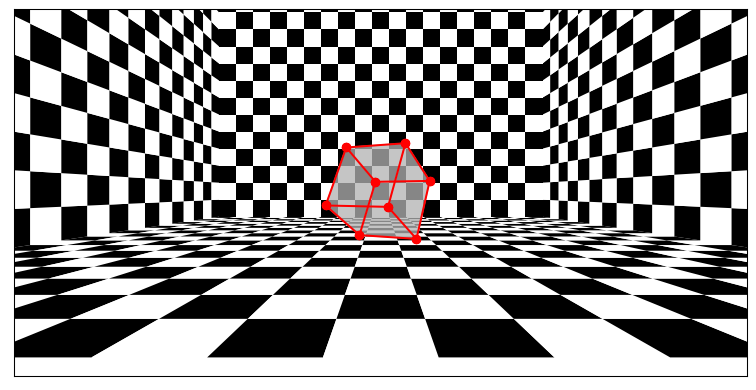

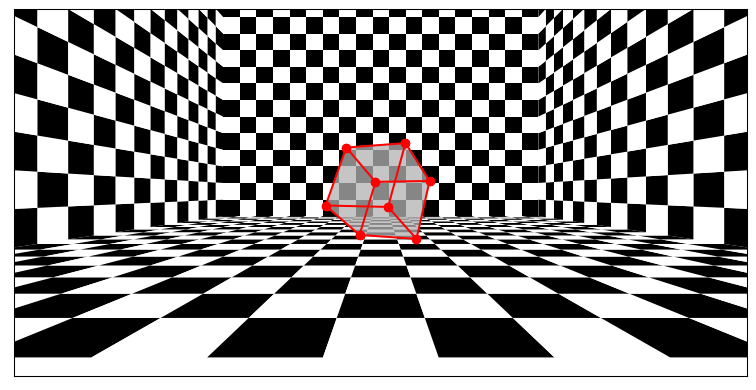

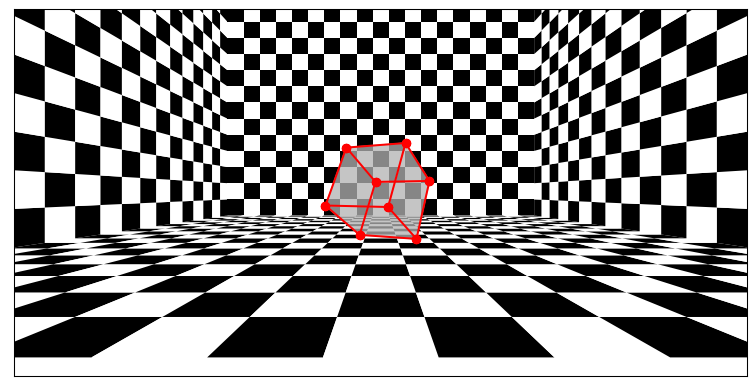

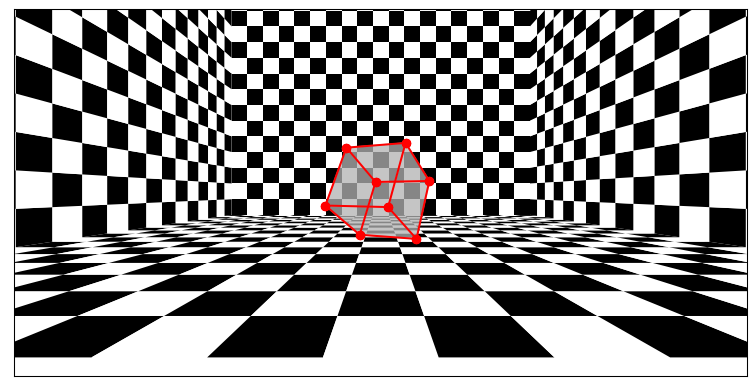

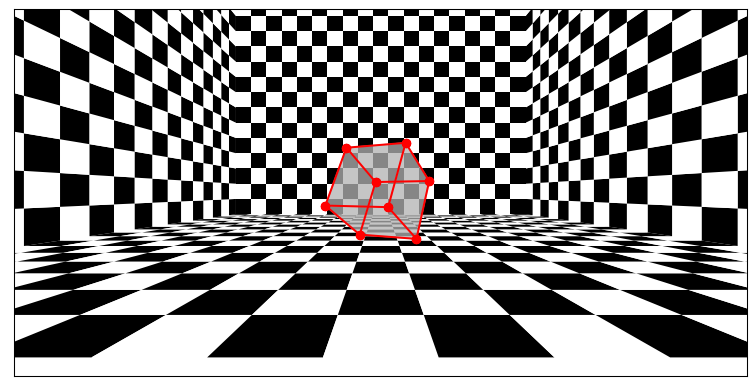

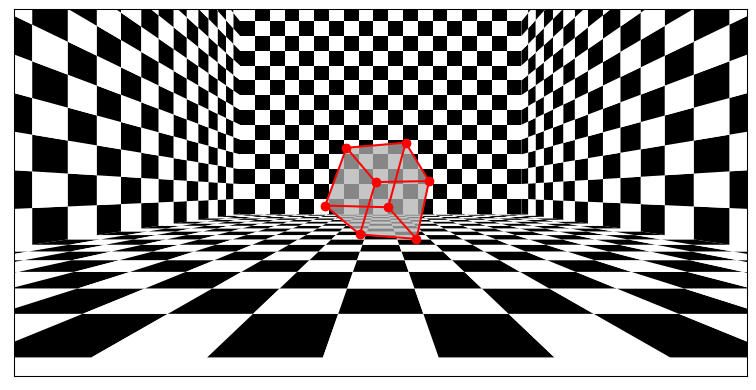

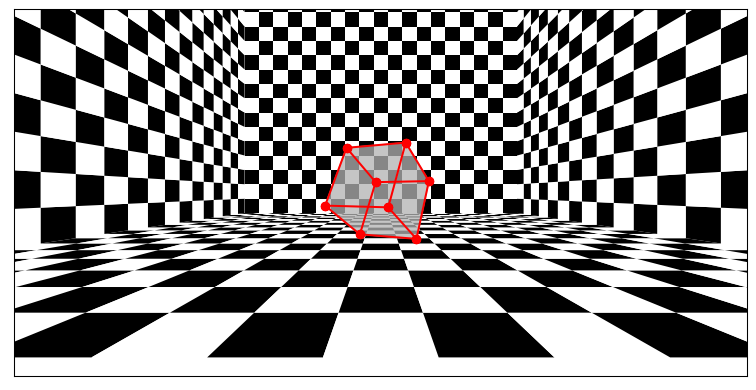

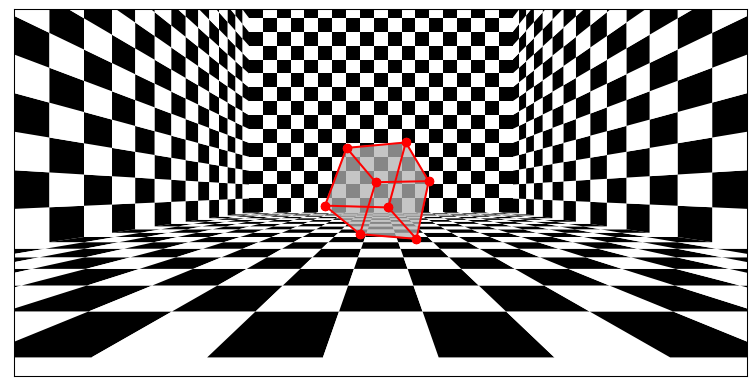

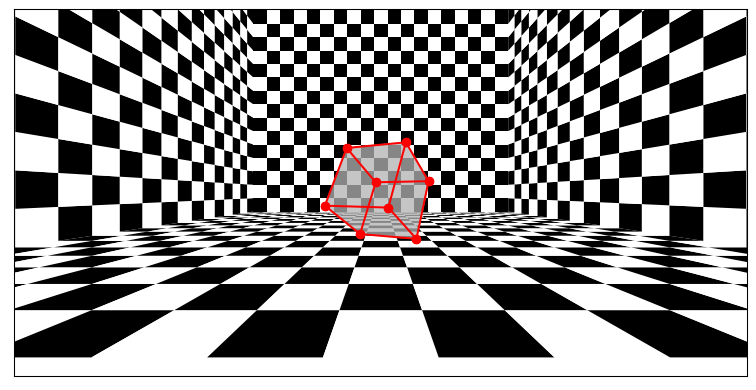

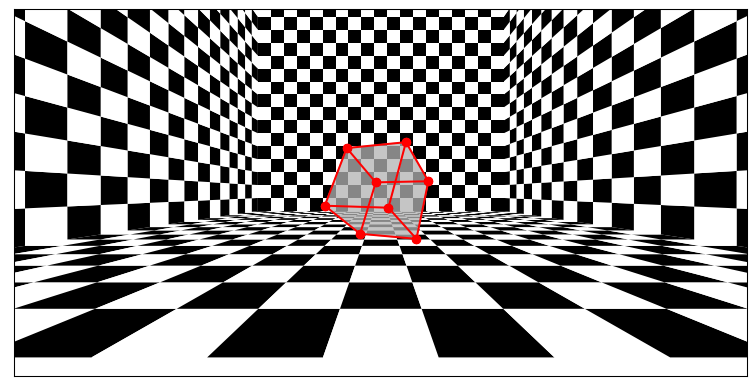

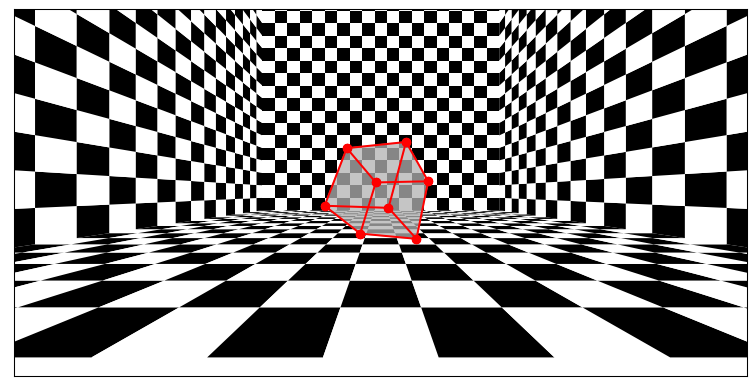

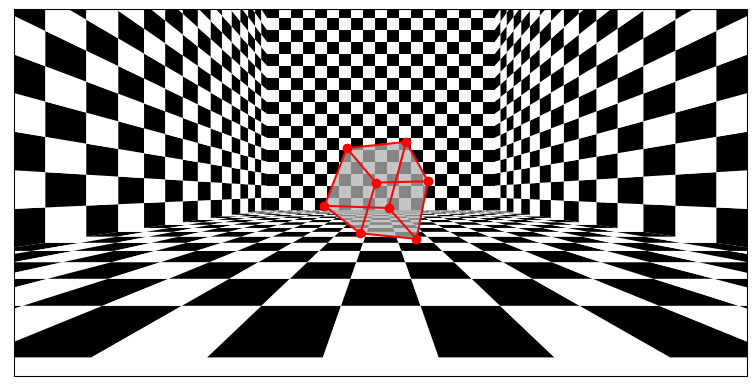

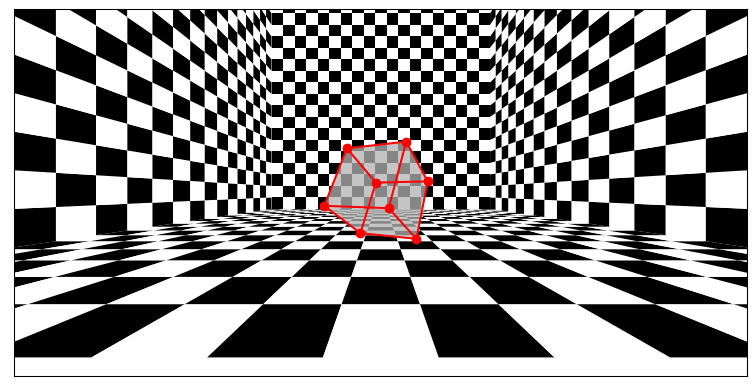

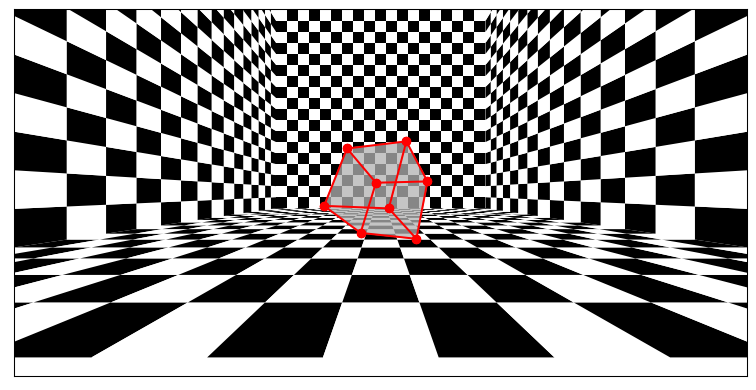

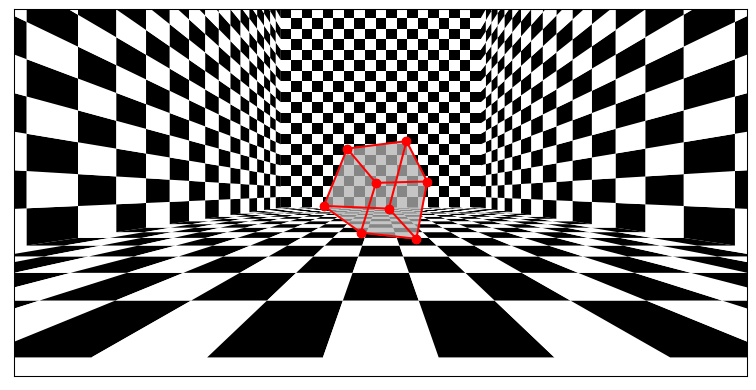

In [21]:
# perform dolly zoom of the entire scene and save as a gif

# these are the z-movement of the scene for dolly
Tzs = np.linspace(Z_start, Z_end, steps)
fs = f_start*Tzs/Z_start

# initialize the animation file
gif_writer = imageio.get_writer('output.gif', mode='I')

# update the scene and generate images
for i in range(steps):
    
    projected_scene = {}
    for k in scene.keys(): # iterate over the objects
        
        # current object in the scene
        cur_obj = copy.deepcopy(scene[k])
        
        # modify the Z-values of the current object in the new_scene
        cur_obj['transform'][-1] = cur_obj['transform'][-1] + (Tzs[i]-Z_start)
        
        # project this objects on the sensor
        projected_scene[k] = transform_points(cur_obj, fs[i])
        
    # visualize the scene
    plot_img = visualize_scene(projected_scene)
    
    # write the current image in the gif
    gif_writer.append_data(plot_img)